In [68]:
import pandas as pd

# -----------------------------
# 1) CSV 로드
# -----------------------------
df_avg = pd.read_csv("wteam_avg.csv")
df_qf  = pd.read_csv("quaterfinals.csv")

# -----------------------------
# 2) 조별리그: Italy / Norway 선택
# -----------------------------
avg_sel = (
    df_avg
    .loc[df_avg["Team"].isin(["Italy", "Norway"]), ["Team", "xG", "BigChances", "Possession(%)"]]
    .rename(columns={"Possession(%)": "Possession"})
    .assign(Stage="Group")
)

# -----------------------------
# 3) 8강 경기 데이터 추출
# -----------------------------
# Round가 Quaterfinals 이고 Italy 또는 Norway가 HomeTeam 또는 AwayTeam인 경기 필터링
qf_filtered = df_qf[
    (df_qf["Round"] == "Quaterfinals") &
    (
        (df_qf["HomeTeam"].isin(["Italy", "Norway"])) |
        (df_qf["AwayTeam"].isin(["Italy", "Norway"]))
    )
]

qf_rows = []
for _, row in qf_filtered.iterrows():
    if row["HomeTeam"] in ["Italy", "Norway"]:
        qf_rows.append({
            "Team": row["HomeTeam"],
            "xG": row["HomexG"],
            "BigChances": row["HomeBigChances"],
            "Possession": row["HomePossession(%)"],
            "Stage": "Quarterfinal"
        })
    if row["AwayTeam"] in ["Italy", "Norway"]:
        qf_rows.append({
            "Team": row["AwayTeam"],
            "xG": row["AwayxG"],
            "BigChances": row["AwayBigChances"],
            "Possession": row["AwayPossession(%)"],
            "Stage": "Quarterfinal"
        })

qf_sel = pd.DataFrame(qf_rows)

# -----------------------------
# 4) 합치기 + 숫자 처리
# -----------------------------
tidy_df = pd.concat([avg_sel, qf_sel], ignore_index=True)

for col in ["xG", "BigChances", "Possession"]:
    tidy_df[col] = pd.to_numeric(tidy_df[col], errors="coerce").round(2)

print(tidy_df)


     Team    xG  BigChances  Possession         Stage
0   Italy  1.46        1.33       38.67         Group
1  Norway  1.38        2.67       49.33         Group
2  Norway  2.28        3.00       50.00  Quarterfinal
3   Italy  2.03        4.00       50.00  Quarterfinal


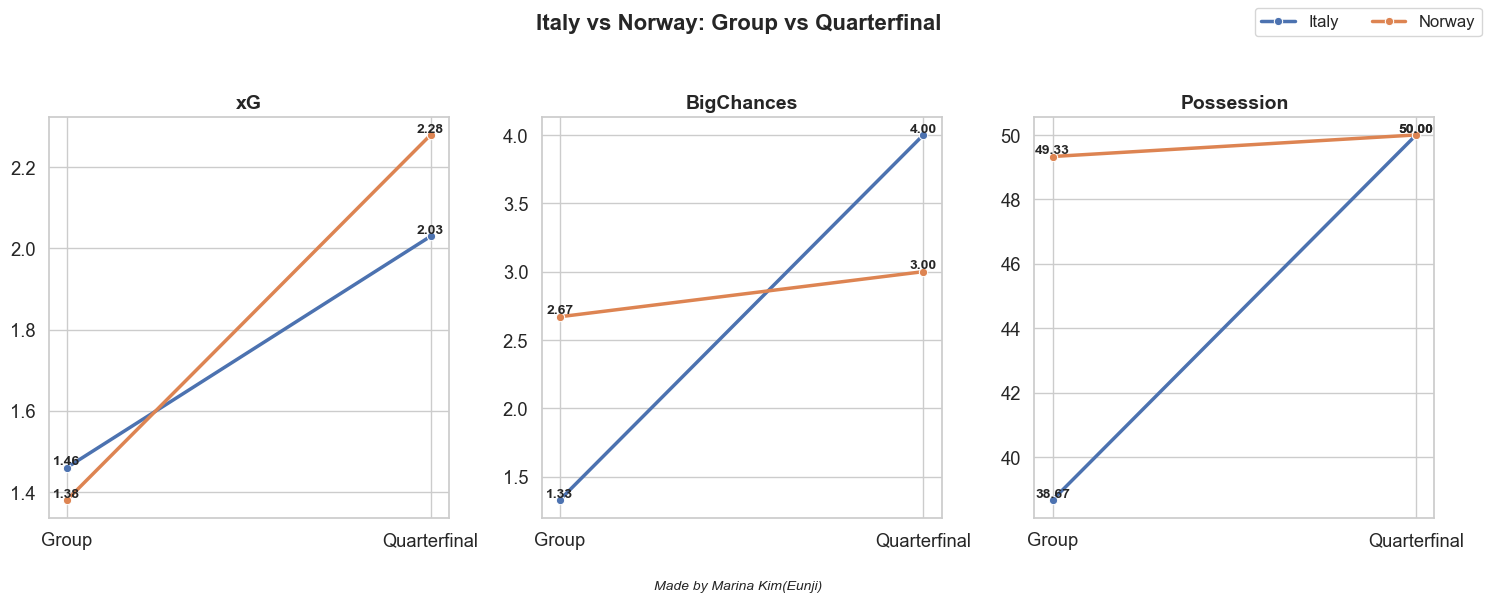

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# 슬로프 차트 스타일 설정
sns.set(style="whitegrid", font="Arial", font_scale=1.2)

# 컬럼 리스트
metrics = ["xG", "BigChances", "Possession"]

# 캔버스 설정 (3개의 서브플롯 가로 배치)
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Stage 순서 지정
stage_order = ["Group", "Quarterfinal"]

for ax, metric in zip(axes, metrics):
    # 슬로프 플롯 (Stage vs 값, Team별 색)
    sns.lineplot(
        data=tidy_df,
        x="Stage", y=metric, hue="Team",
        hue_order=["Italy", "Norway"],
        marker="o", linewidth=2.5, ax=ax
    )

    # 각 점에 숫자 표시
    for team in ["Italy", "Norway"]:
        subset = tidy_df[tidy_df["Team"] == team].sort_values("Stage")
        for i, row in subset.iterrows():
            ax.text(
                x=stage_order.index(row["Stage"]),
                y=row[metric],
                s=f"{row[metric]:.2f}",
                ha="center", va="bottom", fontsize=10, fontweight="bold"
            )

    # 축 & 제목 설정
    ax.set_title(metric, fontsize=14, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks(range(len(stage_order)))
    ax.set_xticklabels(stage_order)
    ax.legend().set_visible(False)

# 전체 제목 & 캡션
fig.suptitle("Italy vs Norway: Group vs Quarterfinal", fontsize=16, fontweight="bold")
fig.text(0.5, 0.02, "Made by Marina Kim(Eunji)", ha="center", fontsize=10, style="italic")

# 범례는 전체에 하나만
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=2, fontsize=12)

# 레이아웃 & 저장
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig("italy_norway_slopecharts.png", dpi=300)
plt.show()
